# Лабораторная работа 3. Решение нелинейных уравнений и систем.

Цель работы:

Решить нелинейное уравнение:
$$\ln x + (x-1)^3=0$$

Уравнение имеет одно точное решение $x = 1$. Локализация корня [0,5; 1.5].

Решить систему нелинейных уравнений:
$$
\begin{equation}\begin{cases}
    \sin x - y=1.32 \\
    \cos y - x=-0.85
\end{cases}\end{equation}
$$

Локализация корней:
$$
x \in [1.5; 2] \\
y \in [-0.5; 0]
$$

In [ ]:
import sys
import numpy
import os
import math
import itertools
import random
import matplotlib.pyplot as plt

### Функции

In [105]:
def MakeDiagonal(A, f):
    for rowIndex in range(len(A)-1, -1, -1):
        columnIndex = rowIndex

        # Уже сделали это в MakeUpDiagonal.
        #f[rowIndex] /= A[rowIndex][columnIndex]
        #A[rowIndex][columnIndex] = 1

        for _rowIndex in range(0, rowIndex):
            f[_rowIndex] -= f[rowIndex] * A[_rowIndex][columnIndex]
            A[_rowIndex][columnIndex] = 0

def MakeUpDiagonal(A, f, findMaxElem):
    for columnIndex in range(0, len(A)):
        rowIndex = columnIndex
        
        # Ищем максимальный элемент.
        if (findMaxElem):
            maxRowIndex = rowIndex
            maxElem = A[rowIndex][columnIndex]
            for _rowIndex in range(rowIndex + 1, len(A)):
                # Если главный элемент равен 0, его нужно заменить.
                if (A[_rowIndex][columnIndex] != 0 and
                    (A[_rowIndex][columnIndex] > maxElem or
                     maxElem == 0)):
                    maxElem = A[_rowIndex][columnIndex]
                    maxRowIndex = _rowIndex
            if (rowIndex != maxRowIndex):
                # Меняем строки местами.
                A[[rowIndex, maxRowIndex]] = A[[maxRowIndex, rowIndex]]
                f[[rowIndex, maxRowIndex]] = f[[maxRowIndex, rowIndex]]

        # Прямой ход метода Гаусса.

        # Делаем диагональный элемент равным 1.
        a = A[rowIndex][columnIndex]
        A[rowIndex] /= a
        f[rowIndex] /= a
        # Присваиваем точное значение, из-за возможной ошибки при округлении.
        A[rowIndex][columnIndex] = 1
        # Обнуляем элементы под диагональным.
        for _rowIndex in range(rowIndex + 1, len(A)):
            f[_rowIndex] -= f[rowIndex] * A[_rowIndex][columnIndex]
            A[_rowIndex] -= A[rowIndex] * A[_rowIndex][columnIndex]
            # Присваиваем точное значение, из-за возможной ошибки при округлении.
            A[_rowIndex][columnIndex] = 0
 
# Решает систему линейных уравнений Ax = f методом Гаусса. 
# Внимание! Изменяет исходные значения A и f.
def SolveGauss(A, f, findMaxElem = True):
    MakeUpDiagonal(A, f, findMaxElem)
    MakeDiagonal(A, f)
    return f

# Находит ошибку решения системы уравнений: residual = Af - s.
def CheckSystemSolution(A, f, s):
    residual = numpy.empty(len(A))
    for rowIndex in range(0, len(A)):
        residual[rowIndex] = numpy.dot(A[rowIndex], s) - f[rowIndex]
    return residual

In [89]:
# Вычисление детерминанта по формуле разложения по строке.
# Медленно работает из-за постоянного выделения памяти для миноров.
def MatrixDeterminantVeryVerySlow(A):
    if (len(A) == 1):
        return A[0][0]
    if (len(A) == 2):
        return A[0][0] * A[1][1] - A[1][0] * A[0][1]
    
    det = 0
    sign = 1
    for columnIndex in range(0, len(A)):
        cols = numpy.array(list(range(0, columnIndex)) + list(range(columnIndex + 1, len(A))))
        rows = numpy.arange(1, len(A))
        minor = A[cols[:,numpy.newaxis], rows]
        det += sign * A[0][columnIndex] * MatrixDeterminantVeryVerySlow(minor)
        sign = -sign
    return det

# Методом Гаусса приводим к верхне-диагональному виду, затем находим определить как произведение диагональных элементов верхне-треугольной матрицы.
def MatrixDeterminant1(A, findMaxElem):
    det = 1
    # От первой до предпоследней строки. Последняя строка уже приведена к нужному виду.
    for columnIndex in range(0, len(A) - 1):
        rowIndex = columnIndex
        
        # Ищем максимальный элемент.
        # Строки матрицы можно переставлять, значение определителя поменяет знак.
        if (findMaxElem):
            maxRowIndex = rowIndex
            maxElem = A[rowIndex][columnIndex]
            for _rowIndex in range(rowIndex + 1, len(A)):
                if (A[_rowIndex][columnIndex] > maxElem):
                    maxElem = A[_rowIndex][columnIndex]
                    maxRowIndex = _rowIndex
            if (rowIndex != maxRowIndex):
                # Меняем строки местами.
                A[[rowIndex, maxRowIndex]] = A[[maxRowIndex, rowIndex]]
                det = -det

        # Прямой ход метода Гаусса.
        a = A[rowIndex] / A[rowIndex][columnIndex]
        # Обнуляем элементы под диагональным.
        for _rowIndex in range(rowIndex + 1, len(A)):
            A[_rowIndex] -= a * A[_rowIndex][columnIndex]
            # Присваиваем точное значение, из-за возможной ошибки при округлении.
            A[_rowIndex][columnIndex] = 0
        # Детерминант равен произведению диагональных элементов.
        det *= A[rowIndex][columnIndex]
    det *= A[len(A) - 1, len(A) - 1]
    return det

# Вычисление детерминанта по формуле полного разложения (через перестановки) слишком вычислительно затратный.
# Для формулы полного разложения 100! ~9,332621544×10^157 - слишком большое число. 
# В тоже время метод Гаусса требует ~(2/3 * 100^3 + 100^2) итераций - что приемлемо.

# Нахождение обратной матрицы методом Гаусса.
# Не изменяет исходную матрицу A.
def MatrixInverse1(A):
    invA = numpy.identity(len(A))
    srcA = numpy.empty((len(A), len(A)))
    numpy.copyto(srcA, A)

    MakeUpDiagonal(srcA, invA, False)
    MakeDiagonal(srcA, invA)
    return invA

def MatrixInverse3(A):
    return numpy.linalg.inv(A)

In [90]:
def NormV1(x):
    return numpy.max(numpy.abs(x))

def NormV2(x):
    return numpy.sum(numpy.abs(x))

def NormV3(x):
    return math.sqrt(numpy.dot(x, x))

def NormM1(A):
    # Максимальная сумма по строке модулей элементов.
    result = 0
    for rowIndex in range(0, len(A)):
        sum = 0
        for columnIndex in range(0, len(A)):
            sum += abs(A[rowIndex][columnIndex])
        if (sum > result):
            result = sum
    return result

def NormM2(A):
    # Максимальная сумма по столбцам модулей элементов.
    result = 0
    for columnIndex in range(0, len(A)):
        sum = 0
        for rowIndex in range(0, len(A)):
            sum += abs(A[rowIndex][columnIndex])
        if (sum > result):
            result = sum
    return result

In [71]:
# Метод простой итерации (Fixed-point iterations)
# Решает уравнение F(x) = 0.
def SolveFPI(F, x0, eps, residuals = None, maxIters = 100):
    xn = x0
    iterNum = 1
    while (True):
        xn1 = F(xn)
        r = xn1 - xn

        iterNum += 1
        xn = xn1

        if (residuals is not None):
            residuals.append(r)

        if (abs(r) < eps):
            return xn1

        if (iterNum > maxIters):
            return xn1

def SolveNewthon(F, derF, x0, eps, residuals = None, maxIters = 100):
    newF = lambda xn: xn - F(xn)/derF(xn)
    return SolveFPI(F, x0, eps, residuals, maxIters)

In [85]:
def GetLDU(A):
    D = numpy.zeros((len(A), len(A)))
    L = numpy.zeros((len(A), len(A)))
    U = numpy.zeros((len(A), len(A)))
    
    D[0][0] = A[0][0]
    for st1 in range(1, len(A)):
        for st2 in range(0, st1):
            L[st1][st2] = A[st1][st2]
            U[st2][st1] = A[st2][st1]
        D[st1][st1] = A[st1][st1]
    return (L, D, U)

def SolveIterate(M1, f2, s0, eps, norm, residuals, maxIters):
    sn = numpy.empty(len(M1))
    numpy.copyto(sn, s0)
    iterNum = 1
    while (True):
        f1  = numpy.dot(M1, sn)
        sn1 = f1 + f2
        r   = norm(sn1 - sn)
        sn = sn1

        if (residuals is not None):
            residuals.append(r)

        if (r < eps):
            return sn
        
        iterNum += 1
        if (iterNum > maxIters):
            return sn

def SolveRelaxation(A, f, s0, eps, tau, norm, residuals : list = None, maxIters = 100):
    (L, D, U) = GetLDU(A)
    
    M1 = numpy.dot(
        -MatrixInverse3(D + tau * L),
        (tau - 1) * D + tau * U)
    f2 = numpy.dot(tau * MatrixInverse3(D + tau * L), f)

    return SolveIterate(M1, f2, s0, eps, norm, residuals, maxIters)

def SolveSeidel(A, f, s0, eps, norm, residuals : list = None, maxIters = 100):
    (L, D, U) = GetLDU(A)
    
    M2 = MatrixInverse1(L + D)
    M1 = -numpy.dot(M2, U)
    f2 = numpy.dot(M2, f)

    return SolveIterate(M1, f2, s0, eps, norm, residuals, maxIters)

def SolveJacob(A, f, s0, eps, norm, residuals = None, maxIters = 100):
    (L, D, U) = GetLDU(A)
    
    M2 = MatrixInverse1(D)
    M1 = -numpy.dot(M2, L + U)
    f2 = numpy.dot(M2, f)

    return SolveIterate(M1, f2, s0, eps, norm, residuals, maxIters)

In [210]:
def ApplyFunctionVector(funct, xn):
    res = numpy.empty(len(funct))
    for st in range(0, len(res)):
        res[st] = funct[st](xn)
    return res

def ApplyFunctionMatrix(funct, xn):
    res = numpy.empty((len(funct), len(funct)))
    for st1 in range(0, len(res)):
        for st2 in range(0, len(res)):
            res[st1][st2] = funct[st1][st2](xn)
    return res

def SolveSystemFPI(F, x0, eps, norm, residuals = None, maxIters = 100):
    xn = x0
    iterNum = 1
    while (True):
        xn1 = ApplyFunctionVector(F, xn)
        r = norm(xn1 - xn)

        iterNum += 1
        xn = xn1

        if (residuals is not None):
            residuals.append(r)

        if (abs(r) < eps):
            return xn1

        if (iterNum > maxIters):
            return xn1

def SolveSystemNewthon(F, derF, x0, eps, norm, residuals = None, maxIters = 100):
    xn = x0
    iterNum = 1
    while (True):
        A = ApplyFunctionMatrix(derF, xn)
        f = ApplyFunctionVector(F, xn)
        # A*res = f
        
        #res = SolveGauss(A, f)
        #res = numpy.dot(MatrixInverse3(A), -ApplyFunctionVector(F, xn))

        #xn1 = res + xn
        xn1 = xn - numpy.dot(MatrixInverse3(A), f)
        res = xn1 - xn
        r = norm(res)

        if (False):
            print("xn\n", xn)
            print("A\n", A)
            print("f\n", f)
            print("Gauss:\n", numpy.dot(A, res) - f)
            print("res\n", res)
            print("xn1\n", xn1)

        iterNum += 1
        xn = xn1

        if (residuals is not None):
            residuals.append(r)

        if (abs(r) < eps):
            return xn1

        if (iterNum > maxIters):
            return xn1

### Уравнение

In [73]:
# x_{n+1} = F(x_n)
def TestEqFunc1(x):
    return math.log(x) + (x - 1)**3

def TestEqFunc1Der(x):
    return 1/x + 3 * (x - 1)**2

# x_{n+1} = F(x_n)
def TestEqFunc2(x):
    logx = math.log(x)
    if (logx > 0):
        return 1 + (logx)**(1/3)
    else:
        return 1 - (logx)**(1/3)
    
def TestEqFunc2Der(x):
    logx = math.log(x)
    return 1/3 * (logx)**(-2/3) * 1/x

# x_{n+1} = F(x_n)
def TestEqFunc3(x):
    return math.exp(-(x - 1)**3)

def TestEqFunc3Der(x):
    return math.exp(-(x - 1)**3) * (-3) * (x-1)**2


### Метод простой итерации

TestEqFunc1 и TestEqFunc2 не сошлись. 

Корень: 1.000000000000000
Начальное приближение: 1.5
Ошибка нахождения корня:
    x_ист - x_приб = 0.000000
Погрешность решения уравнения:
    F(x_приб) - 0 = 1.000000



/tmp/ipykernel_13927/3548372852.py:17: RuntimeWarning: divide by zero encountered in log10
  plt.plot(numpy.arange(1, len(res) + 1), numpy.log10(numpy.abs(res)), label = "$x_0 = {}$".format(x0))


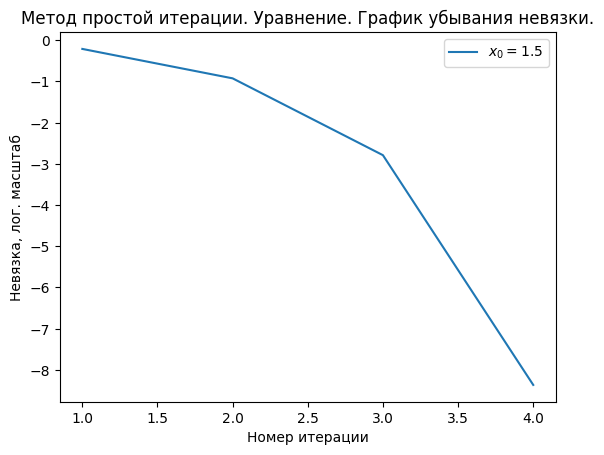

In [214]:
res  = []
funct = TestEqFunc3
x0 = 1.5
sol  = SolveFPI(funct, x0, 1e-10, res)

r = funct(sol)

print("""\
Корень: {:.15f}
Начальное приближение: {}
Ошибка нахождения корня:
    x_ист - x_приб = {:f}
Погрешность решения уравнения:
    F(x_приб) - 0 = {:f}
""".format(sol, x0, 1 - sol, funct(sol)))

plt.plot(numpy.arange(1, len(res) + 1), numpy.log10(numpy.abs(res)), label = "$x_0 = {}$".format(x0))

plt.legend()
plt.xlabel("Номер итерации")
plt.ylabel("Невязка, лог. масштаб")
plt.title("Метод простой итерации. Уравнение. График убывания невязки.")
plt.show()

### Метод Ньютона

1 + sign(ln x) * (ln x)**(1/3)
Корень: 1.850651211945762
Начальное приближение: 1.5
Ошибка нахождения корня:
    x_ист - x_приб = -0.850651
Погрешность решения уравнения:
    F(x_приб) - 0 = 0.540350

math.exp(-(x - 1)**3)
Корень: 1.000000000000000
Начальное приближение: 1.5
Ошибка нахождения корня:
    x_ист - x_приб = 0.000000
Погрешность решения уравнения:
    F(x_приб) - 0 = 1.000000



/tmp/ipykernel_13927/120839622.py:31: RuntimeWarning: divide by zero encountered in log10
  plt.plot(numpy.arange(1, len(res2) + 1), numpy.log10(numpy.abs(res2)), label = "$x_{{n+1}} = e^{{-(x_n-1)^3}}$, $x_0 = {}$".format(x0))


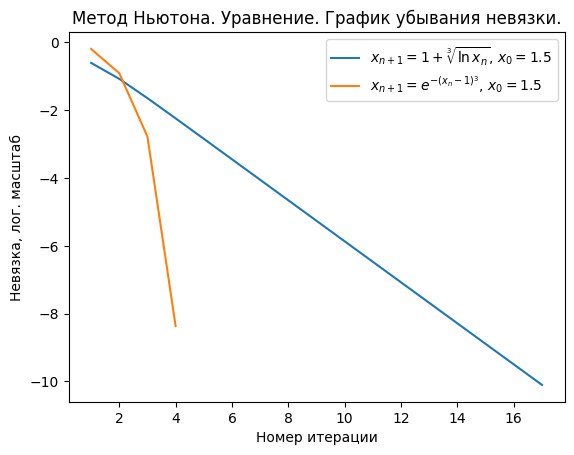

In [215]:
res1  = []
res2  = []
x01 = 1.5
sol1 = SolveNewthon(TestEqFunc2, TestEqFunc2Der, x0, 1e-10, res1)
sol2 = SolveNewthon(TestEqFunc3, TestEqFunc3Der, x0, 1e-10, res2)

r1 = funct(sol1)
r2 = funct(sol2)

print("""\
1 + sign(ln x) * (ln x)**(1/3)
Корень: {:.15f}
Начальное приближение: {}
Ошибка нахождения корня:
    x_ист - x_приб = {:f}
Погрешность решения уравнения:
    F(x_приб) - 0 = {:f}
""".format(sol1, x0, 1 - sol1, r1))

print("""\
math.exp(-(x - 1)**3)
Корень: {:.15f}
Начальное приближение: {}
Ошибка нахождения корня:
    x_ист - x_приб = {:f}
Погрешность решения уравнения:
    F(x_приб) - 0 = {:f}
""".format(sol2, x0, 1 - sol2, r2))

plt.plot(numpy.arange(1, len(res1) + 1), numpy.log10(numpy.abs(res1)), label = "$x_{{n+1}} = 1 + \\sqrt[3]{{\\ln x_n}}$, $x_0 = {}$".format(x0))
plt.plot(numpy.arange(1, len(res2) + 1), numpy.log10(numpy.abs(res2)), label = "$x_{{n+1}} = e^{{-(x_n-1)^3}}$, $x_0 = {}$".format(x0))

plt.legend()
plt.xlabel("Номер итерации")
plt.ylabel("Невязка, лог. масштаб")
plt.title("Метод Ньютона. Уравнение. График убывания невязки.")
plt.show()

### Система уравнений

In [203]:
System1 = numpy.array([
    lambda v: math.cos(v[1]) + 0.85,
    lambda v: math.sin(v[0]) - 1.32
])

SystemRes = numpy.array([
    lambda v: math.sin(v[0]) - v[1] - 1.32,
    lambda v: math.cos(v[1]) - v[0] + 0.85
])

System2 = numpy.array([
    lambda v: math.cos(v[1]) - v[0] + 0.85,
    lambda v: math.sin(v[0]) - v[1] - 1.32
])

System2Der = numpy.array([
    [lambda v: -1, lambda v: -math.sin(v[1])],
    [lambda v: math.cos(v[0]), lambda v: -1]
])

### Метод простой итерации решения системы нелинейных уравнений

Корень:
[ 1.79134041 -0.34422193]
Начальное приближение:
[ 1.9 -0.1]
Погрешность решения уравнения F(x_приб) - 0:
[ 4.9601790e-07 -2.0972144e-06]


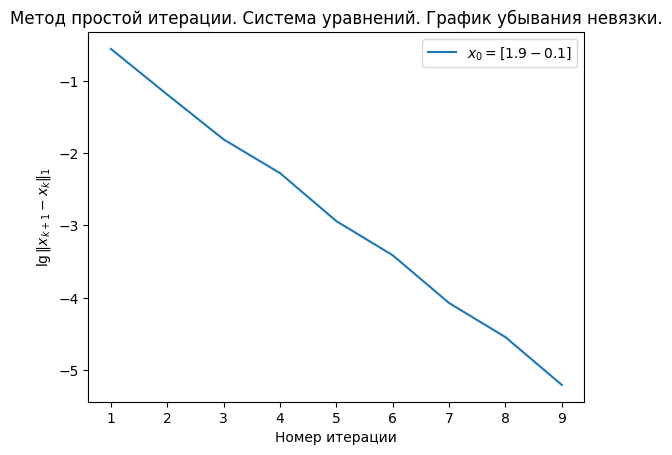

In [216]:
res  = []
x0 = numpy.array([1.9, -0.1])
sol = SolveSystemFPI(System1, x0, 1e-5, NormV1, res)

r = ApplyFunctionVector(SystemRes, sol)

print("Корень:", sol, sep = '\n')
print("Начальное приближение:", x0, sep = '\n')
print("Погрешность решения уравнения F(x_приб) - 0:", r, sep = '\n')

plt.plot(numpy.arange(1, len(res) + 1), numpy.log10(res), label = "$x_0 = {}$".format(x0))

plt.legend()
plt.xlabel("Номер итерации")
plt.ylabel("$\lg \|x_{k+1} - x_{k}\|_1$")
plt.title("Метод простой итерации. Система уравнений. График убывания невязки.")
plt.show()

### Метод Ньютона решения системы нелинейных уравнений

Корень:
[ 1.79133861 -0.34422104]
Начальное приближение:
[ 1.5 -0.1]
Погрешность решения уравнения F(x_приб) - 0:
[-1.99840144e-14 -1.08357767e-13]


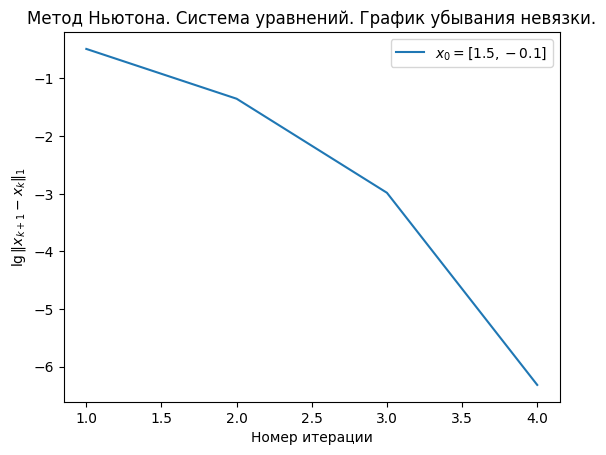

In [217]:
res  = []
x0 = numpy.array([1.5, -0.1])
sol = SolveSystemNewthon(System2, System2Der, x0, 1e-5, NormV1, res, 20)

r = ApplyFunctionVector(SystemRes, sol)

print("Корень:", sol, sep = '\n')
print("Начальное приближение:", x0, sep = '\n')
print("Погрешность решения уравнения F(x_приб) - 0:", r, sep = '\n')

plt.plot(numpy.arange(1, len(res) + 1), numpy.log10(res), label = "$x_0 = [{}, {}]$".format(x0[0], x0[1]))

plt.legend()
plt.xlabel("Номер итерации")
plt.ylabel("$\lg \|x_{k+1} - x_{k}\|_1$")
plt.title("Метод Ньютона. Система уравнений. График убывания невязки.")
plt.show()